In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, RandomSampler, Subset


import torchvision
import torchvision.transforms.v2
from torchvision import models
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url

from tqdm import tqdm

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import PIL
import os
import pandas as pd
import cv2
import numpy as np
import requests

# Dataset

In [2]:
# found this in: https://github.com/TDeVries/cub2011_dataset/blob/master/cub2011.py
class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, loader=default_loader, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        bounding_boxes = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'bounding_boxes.txt'),
                                         sep=' ', names=['img_id', 'x1', "y1", "x2", "y2"])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        overlaps = self._get_overlaps()
        if overlaps is not None:
            images['image_name'] = images['filepath'].str.split("/").str[-1]
            overlaps = overlaps.merge(images, left_on='cub_name', right_on='image_name')
            overlaps['is_training_img'] = 1
            train_test_split.update(overlaps)


        self.data = images.merge(image_class_labels, on='img_id')
        self.data = self.data.merge(train_test_split, on='img_id')
        self.data = self.data.merge(bounding_boxes, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def _get_overlaps(self):
        try:
            download_url('https://gist.githubusercontent.com/arunmallya/a6889f151483dcb348fa70523cb4f578/raw/1ae0992b71375f63bd3779ac41eff4455918a6a8/matches.txt',
                         root=self.root,
                         filename='overlaps.txt')
            return pd.read_csv(os.path.join(self.root, 'overlaps.txt'),
                                    sep=' -> ', names=['cub_name', 'imagenet_name'])
        except Exception:
            return None




    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)
        box = (sample.x1, sample.y1, sample.x2+sample.x1, sample.y2+sample.y1)

        if self.transform is not None:
            img = self.transform(img)

        return img, target, box

In [3]:
test_data_set = Cub2011(os.path.abspath("./data"), train=False)
train_data_set = Cub2011(os.path.abspath("./data"), train=True)

100%|██████████| 1150585339/1150585339 [00:59<00:00, 19223080.13it/s]


100%|██████████| 2404/2404 [00:00<00:00, 1863101.78it/s]
<ipython-input-2-f930477bf5de>:78: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(os.path.join(self.root, 'overlaps.txt'),


Using downloaded and verified file: /content/data/overlaps.txt


<ipython-input-2-f930477bf5de>:78: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(os.path.join(self.root, 'overlaps.txt'),


Files already downloaded and verified
Using downloaded and verified file: /content/data/overlaps.txt


<ipython-input-2-f930477bf5de>:78: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(os.path.join(self.root, 'overlaps.txt'),


# Box proposals

In [30]:
def sliding_window(image: np.ndarray, step_size=50, box_growth=50, min_window_size=(100, 100), max_window_size=None):
    if max_window_size is None:
        max_window_size = (image.shape[0], image.shape[1])

    box_sizes = []
    for box_height in range(min_window_size[0], max_window_size[0]+box_growth, box_growth):
        box_height = min(box_height, max_window_size[0])
        for box_width in range(min_window_size[1], max_window_size[1]+box_growth, box_growth):
            box_width = min(box_width, max_window_size[1])
            if box_height > 3*box_width or box_width > 3*box_height:
                continue
            box_sizes.append((box_height, box_width))

    rect_list = []
    for box_size in box_sizes:
        for y in range(0, image.shape[0] - box_size[0] + step_size, step_size):
            y = min(y, image.shape[0]-box_size[0])
            for x in range(0, image.shape[1] - box_size[1] + step_size, step_size):
                x = min(x, image.shape[1]-box_size[1])
                rect_list.append((x, y, x + box_size[1], y + box_size[0]))
    return rect_list

In [5]:
def selective_search(image: np.ndarray, min_size=100, max_size=400):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)

    #ss.switchToSelectiveSearchQuality() # it is slower and return more boxes
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    filtered_rects = [(x, y, x + w, y + h) for (x, y, w, h) in rects if min_size <= w <= max_size and min_size <= h <= max_size]
    return filtered_rects


In [35]:
url = "https://github.com/opencv/opencv_extra/raw/master/testdata/cv/ximgproc/model.yml.gz"
destination_path = "model.yml.gz"

response = requests.get(url, stream=True)
with open(destination_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=128):
        file.write(chunk)

def generate_edgeboxes(image: np.ndarray,  min_size=100):

    edge_detection = cv2.ximgproc.createStructuredEdgeDetection("model.yml.gz")
    edges = edge_detection.detectEdges(np.float32(image) / 255.0)

    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap)

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(30)
    boxes,score = edge_boxes.getBoundingBoxes(edges, orimap)
    filtered_rects = [(x, y, x + w, y + h) for (x, y, w, h) in boxes if min_size <= w  and min_size <= h ]
    return filtered_rects

## Test box proposals

In [9]:
def boxes_heatmap(image: np.ndarray, rect_list):
    boxes_mask = np.zeros_like(image)
    beta = 1/(len(rect_list)+1)
    for (x, y, x2, y2) in rect_list:
        box = np.zeros_like(image)
        cv2.rectangle(box, (x, y), (x2, y2), (0, 255, 0), -1)
        boxes_mask = cv2.addWeighted(boxes_mask, 1., box, beta, 0.)
    return boxes_mask
    #return cv2.add(image.copy(), boxes_mask)

def boxes_borders(image: np.ndarray, rect_list):
    out = image.copy()
    for (x, y, x2, y2) in rect_list:
        cv2.rectangle(out, (x, y), (x2, y2), (0, 255, 0), 1)
    return out

def plot_box_proposals(image: np.ndarray, rect_list):
    fig, ax = plt.subplots()
    fig.set_figwidth(15)

    ax1 = plt.subplot(1, 2, 1)
    borders = boxes_borders(image, rect_list)
    ax1.imshow(borders)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    ax2 = plt.subplot(1, 2, 2)
    heat_map = boxes_heatmap(image, rect_list)
    ax2.imshow(heat_map)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

In [7]:
train_data_set = Cub2011(os.path.abspath("./data"), train=True)
images = [ np.array(train_data_set.__getitem__(i)[0]) for i in np.random.choice(train_data_set.__len__(), 5) ]

Using downloaded and verified file: /content/data/overlaps.txt


<ipython-input-2-f930477bf5de>:78: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(os.path.join(self.root, 'overlaps.txt'),


Files already downloaded and verified
Using downloaded and verified file: /content/data/overlaps.txt


<ipython-input-2-f930477bf5de>:78: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(os.path.join(self.root, 'overlaps.txt'),


<ipython-input-21-b23491717697>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1)


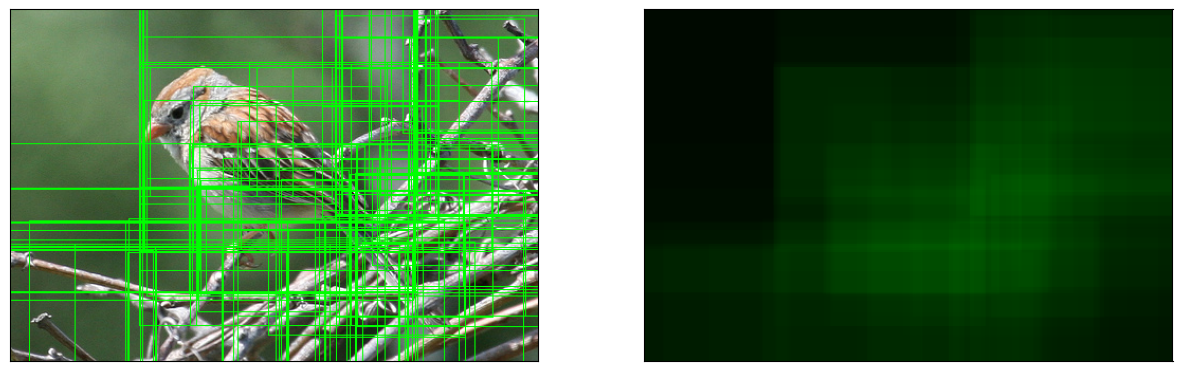

187


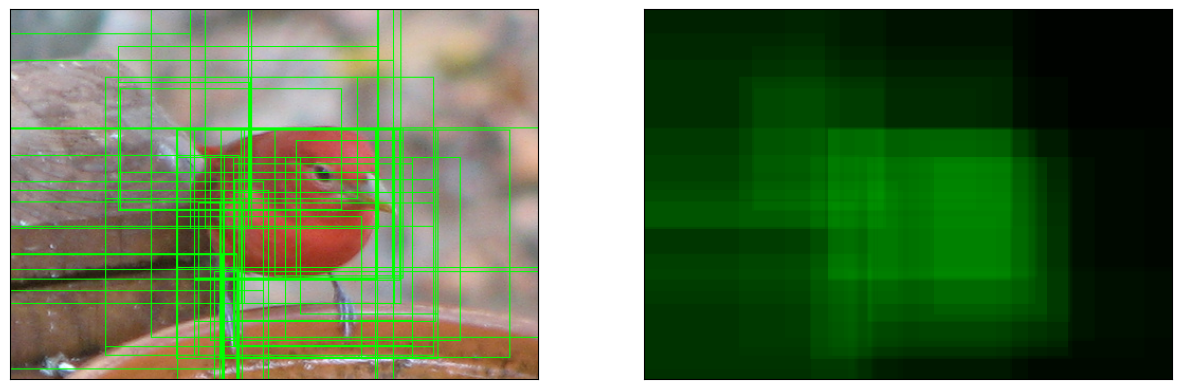

75


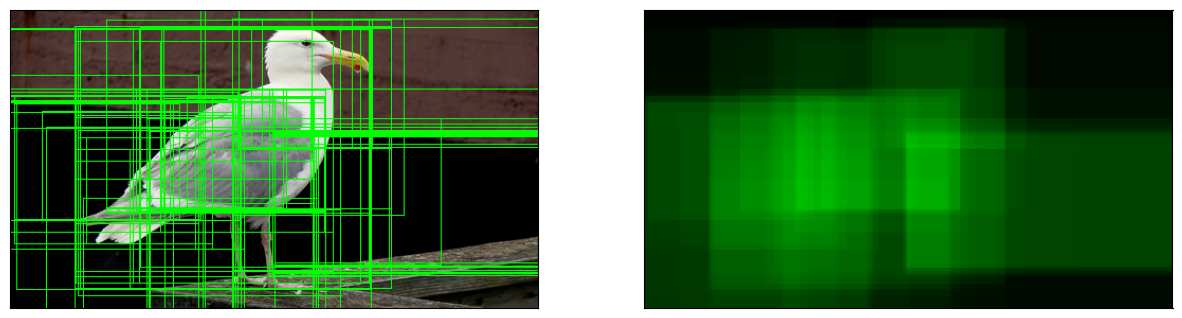

144


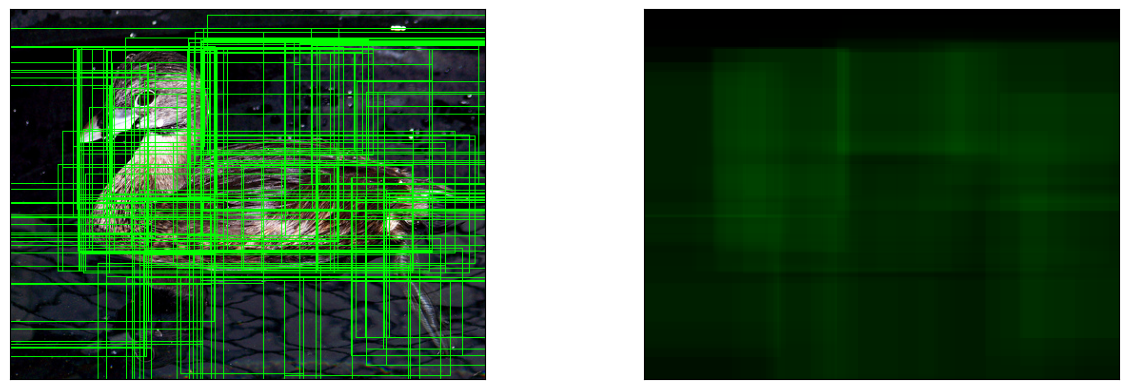

228


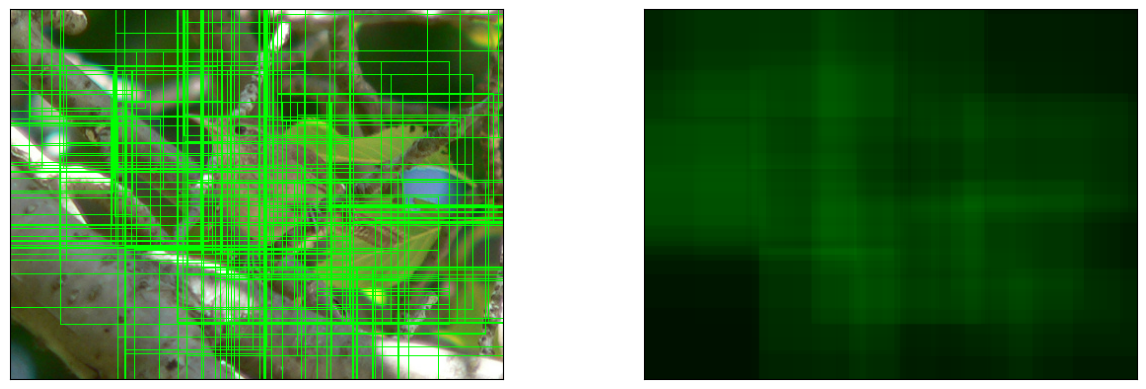

251


In [ ]:
for img in images:
    rect_list = selective_search(img)
    plot_box_proposals(img, rect_list)
    print(len(rect_list))

<ipython-input-9-cd0efd50972d>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1)


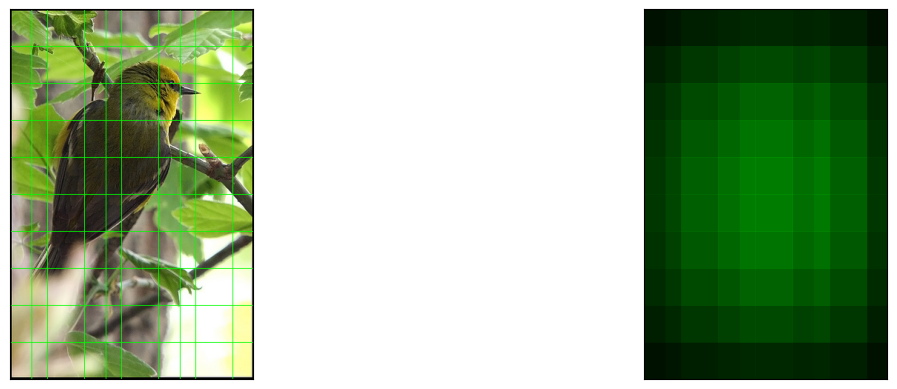

292


In [10]:
rect_list = sliding_window(images[0], step_size=50, box_growth=100, min_window_size=(100, 100))
plot_box_proposals(images[0], rect_list)
print(len(rect_list))

<ipython-input-9-cd0efd50972d>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1)


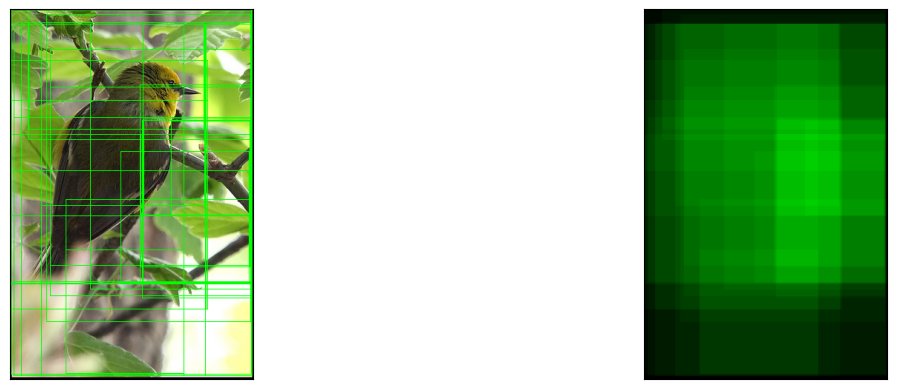

27


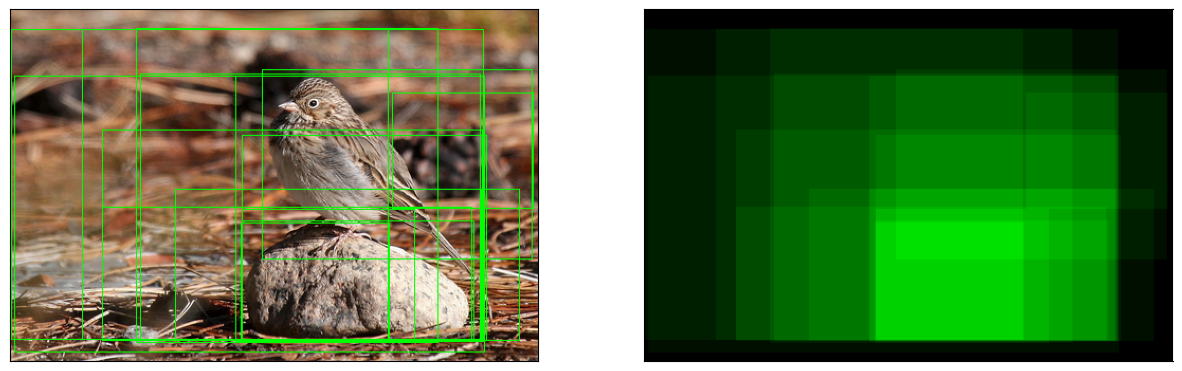

16


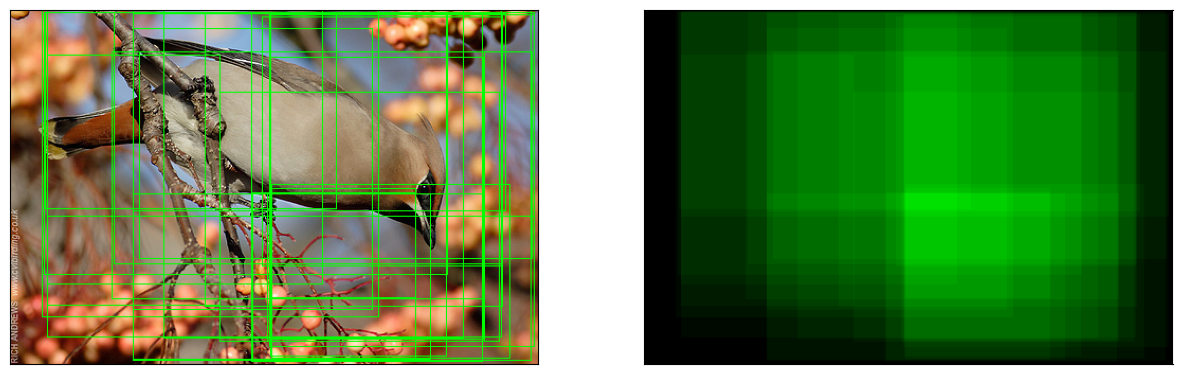

26


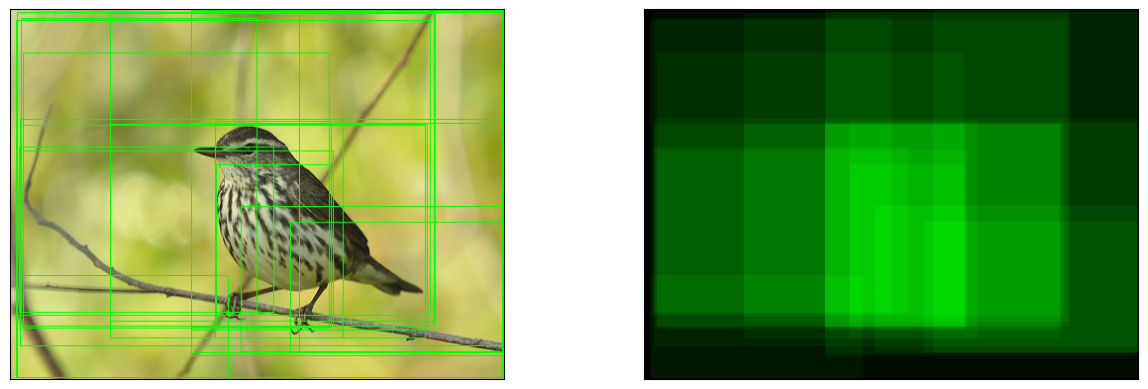

21


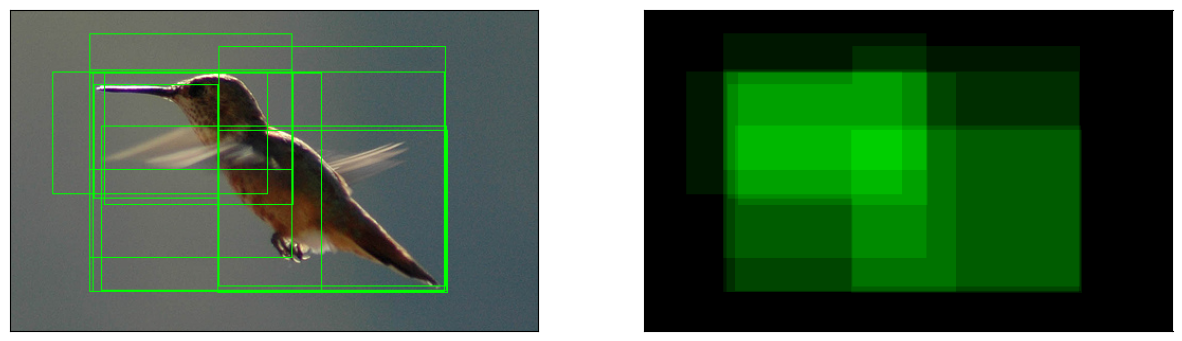

10


In [34]:
for img in images:
    rect_list = generate_edgeboxes(img)
    plot_box_proposals(img, rect_list)
    print(len(rect_list))

# Model

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_state_dict = torch.load('/content/gdrive/MyDrive/models/model_full_acc0.75_overfit.pth')
model = models.vgg16_bn()

model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 200)

model.load_state_dict(loaded_state_dict)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
base_transform = models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()


def predict(model, image: torch.Tensor):
    model.eval()

    with torch.no_grad():
        image = image.to(device)

        output = model(image)

        value, predicted = torch.max(output, 1)

    return value, predicted

## Test model

In [ ]:
# test model
count, correct_count = 0, 0
for (image, label, box) in tqdm(test_data_set):
    count += 1
    image = base_transform(image).unsqueeze(0)
    if predict(model, image)[1] == label:
        correct_count += 1
print(correct_count, count)
print("acc: ", correct_count/count)

100%|██████████| 5773/5773 [01:33<00:00, 61.54it/s]

4345 5773
acc:  0.752641607483111


In [ ]:
# test model again in training set
count, correct_count = 0, 0
for (image, label, box) in tqdm(train_data_set):
    count += 1
    image = base_transform(image).unsqueeze(0)
    if predict(model, image)[1] == label:
        correct_count += 1
print(correct_count, count)
print("acc: ", correct_count/count) # #OVERFIT

100%|██████████| 6015/6015 [01:36<00:00, 62.32it/s]

5797 6015
acc:  0.9637572734829593


# Cropping

In [13]:
def to_sub_images(image: PIL.Image.Image, rect_list):
    cropped_image_list = [image.crop((x1, y1, x2, y2)) for (x1, y1, x2, y2) in rect_list]
    return cropped_image_list

def vectorize(images, transform):
    return torch.stack([transform(img) for img in images])


In [14]:
base_transform = models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()
squeeze_transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.ToTensor(),
    torchvision.transforms.v2.Resize(size=(base_transform.crop_size[0], base_transform.crop_size[0]), antialias=True),
    torchvision.transforms.v2.Normalize(mean=base_transform.mean, std=base_transform.std),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## Test Cropping

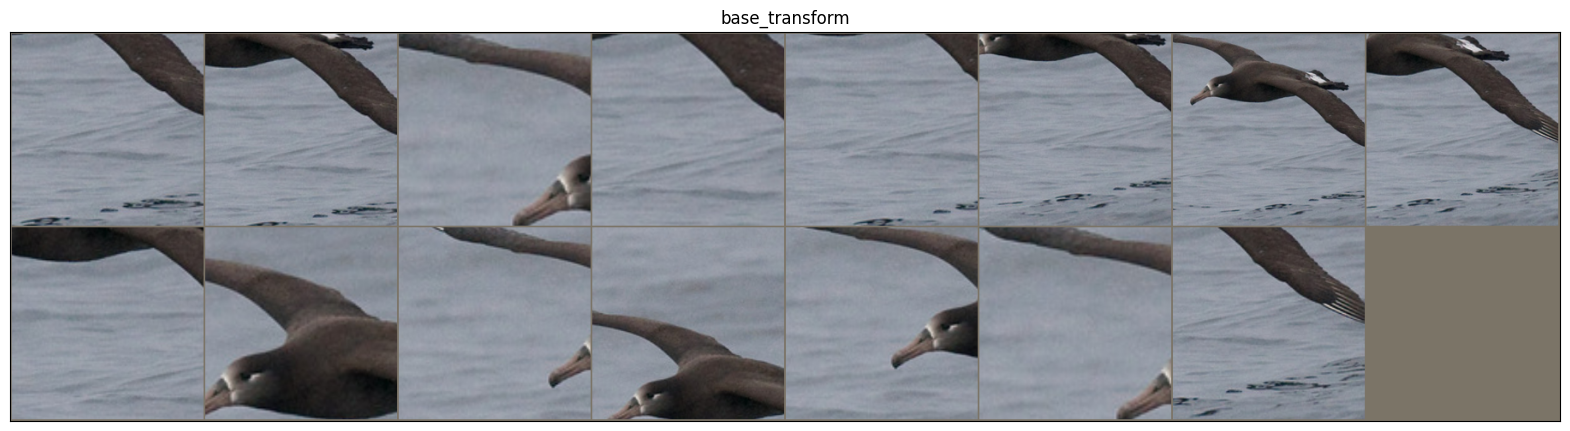

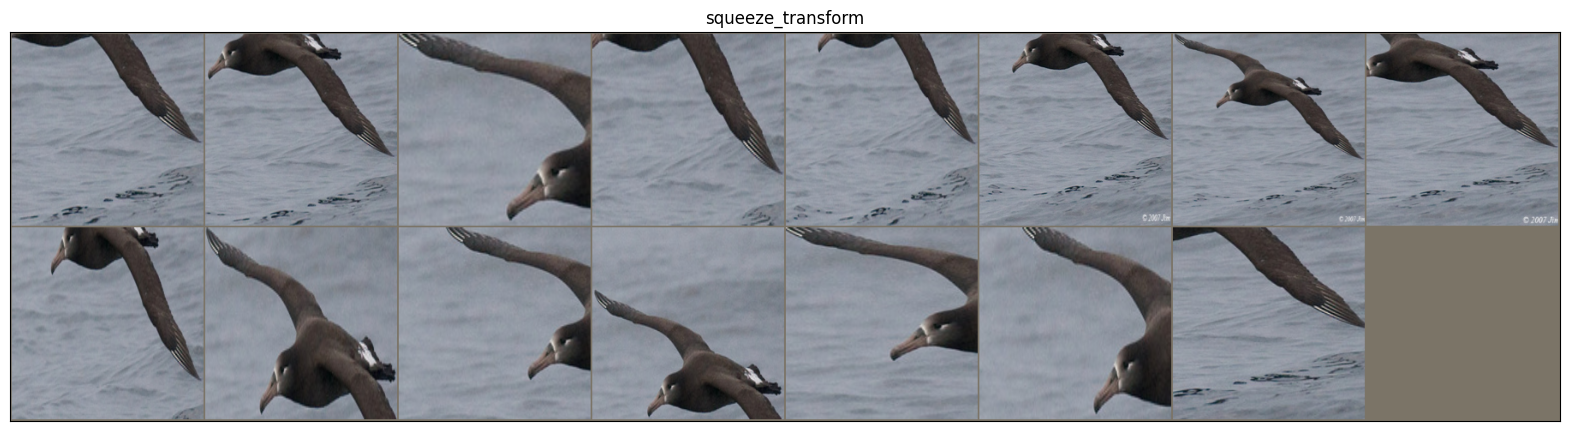

In [ ]:
image: PIL.Image.Image = test_data_set[1][0]

rect_list = generate_edgeboxes(np.array(image))
cropped_images = to_sub_images(image, rect_list)

base_images = vectorize(cropped_images[:32], base_transform)
sample = torchvision.utils.make_grid(base_images)
sample = sample.numpy().transpose((1, 2, 0))
#undo normalization
sample = base_transform.std * sample + base_transform.mean
plt.figure(figsize=(20, 16))
fig = plt.imshow(sample)
fig.axes.set_title("base_transform")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

squeezed_images = vectorize(cropped_images, squeeze_transform)
sample = torchvision.utils.make_grid(squeezed_images[:32])
sample = sample.numpy().transpose((1, 2, 0))
#undo normalization
sample = base_transform.std * sample + base_transform.mean
plt.figure(figsize=(20, 16))
fig = plt.imshow(sample)
fig.axes.set_title("squeeze_transform")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

# Localization Model

In [15]:
def compute_localization_one_image(image: PIL.Image.Image, model, box_method, crop_transform):
    rect_list = box_method(np.array(image))
    if len(rect_list) == 0:
        return -1, (0,0,0,0)

    model.eval()
    with torch.no_grad():
        input = base_transform(image).unsqueeze(0).to(device)
        output = model(input)
        _, predicted_label = torch.max(output, 1)

        cropped_images = to_sub_images(image, rect_list)
        values = []
        for cropped_image in cropped_images:
            input = crop_transform(cropped_image).unsqueeze(0).to(device)
            output = model(input)
            values.append(output[0, predicted_label])

        box_index = np.argmax(torch.tensor(values))

        return predicted_label, rect_list[box_index]

## Test localization model

In [16]:
def plot_boxes(image, predicted_box, true_box, predicted_label, true_label):
    image = np.array(image)
    image = image.copy()
    cv2.rectangle(image, (int(predicted_box[0]), int(predicted_box[1])), (int(predicted_box[2]), int(predicted_box[3])), (0, 255, 0), 2)
    cv2.rectangle(image, (int(true_box[0]), int(true_box[1])), (int(true_box[2]), int(true_box[3])), (225, 0, 200), 2)
    plt.figure()

    green_label = mpatches.Patch(color=(0, 255/255, 0), label='predicted box')
    pink_label = mpatches.Patch(color=(225/255, 0, 200/255), label='true box')
    plt.legend(handles=[green_label, pink_label])

    fig = plt.imshow(image)
    fig.axes.set_title(f"predicted/true: {predicted_label}/{true_label}")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [17]:
data_points = Subset(test_data_set, list(RandomSampler(test_data_set, num_samples=5)))

In [20]:
box_method = lambda img: sliding_window(img, box_growth=50, min_window_size=(50, 50)) # edge_boxes, sliding_window, selective_search

After looking at exeriment bellow, it seems like squeeze_transform produces better bounding boxes. But it is just intuition. Need to verify the performance in the next section.

### Base transform

100%|██████████| 5/5 [01:18<00:00, 15.74s/it]


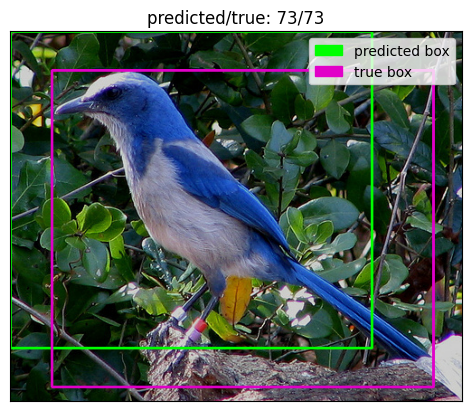

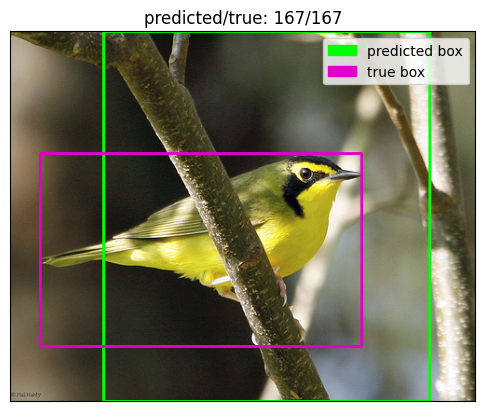

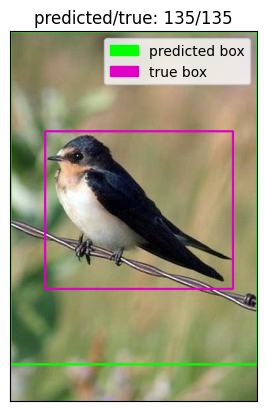

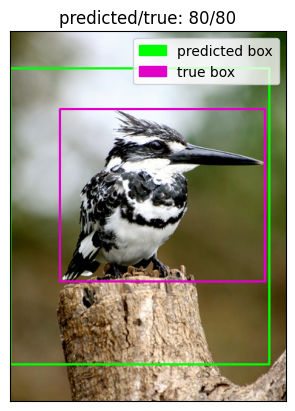

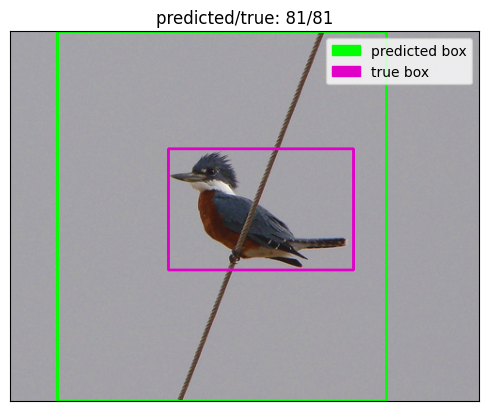

In [21]:
for (image, label, box) in tqdm(data_points):
    predicted_label, predict_box = compute_localization_one_image(image, model, box_method, base_transform)
    plot_boxes(image, predict_box, box, predicted_label.item(), label)

### Squeeze transform

100%|██████████| 5/5 [01:18<00:00, 15.63s/it]


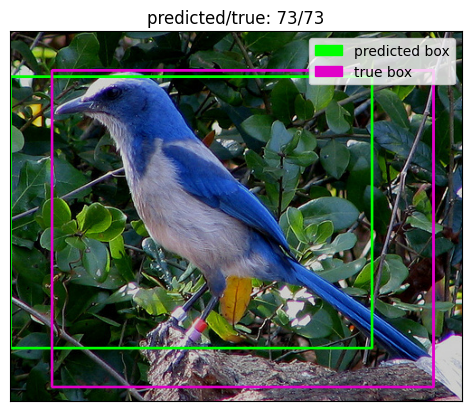

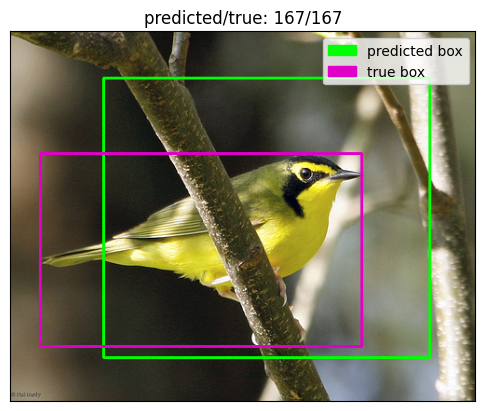

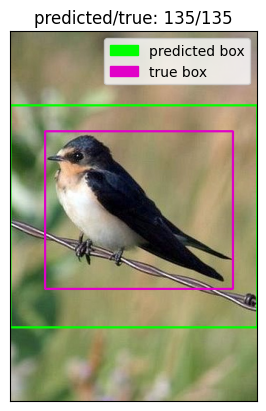

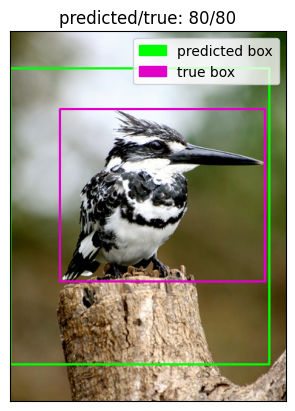

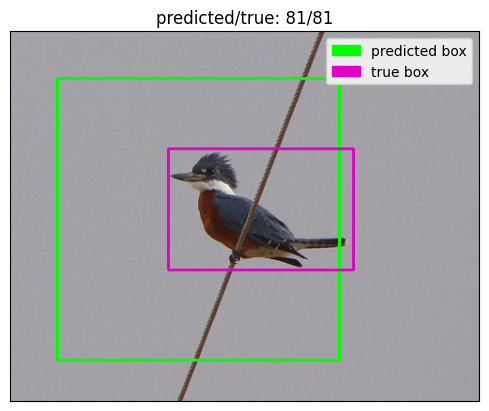

In [22]:
for (image, label, box) in tqdm(data_points):
    predicted_label, predict_box = compute_localization_one_image(image, model, box_method, squeeze_transform)
    plot_boxes(image, predict_box, box, predicted_label.item(), label)

## Test localization performance

In [23]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

print(bb_intersection_over_union((0,0,4,4), (2,2,6,6)))

0.21951219512195122


In [27]:
def test_localization_performance(data_set, model, box_method, crop_transform):
    no_classified = 0
    no_localized = 0
    num_samples = data_set.__len__()
    intersection_over_union_sum = 0.
    for (image, label, box) in tqdm(data_set):
        predicted_label, predicted_box = compute_localization_one_image(image, model, box_method, crop_transform)
        if predicted_label.item() != label:
            continue
        no_classified += 1
        iou = bb_intersection_over_union(predicted_box, box)
        if iou >= 0.5:
            no_localized += 1
            intersection_over_union_sum += iou

    print()
    print(f"Correctly classified: {no_classified/num_samples}")
    print(f"Correctly classified and localized: {no_localized/num_samples}")
    print(f"Average intersection over union of correctly classified: {intersection_over_union_sum/no_classified}")

In [ ]:
num_samples = 100
data_points = Subset(test_data_set, list(RandomSampler(test_data_set, num_samples=num_samples)))

In [36]:

box_method = generate_edgeboxes # edge_boxes, sliding_window, selective_search
crop_transform = squeeze_transform # squeeze_transform, base_transform
test_localization_performance(data_points, model, box_method, crop_transform)

100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


Correctly classified: 0.75
Correctly classified and localized: 0.41
Average intersection over union of correctly classified: 0.3695934745651942


In [37]:
box_method = generate_edgeboxes # edge_boxes, sliding_window, selective_search
crop_transform = base_transform # squeeze_transform, base_transform
test_localization_performance(data_points, model, box_method, crop_transform)

100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


Correctly classified: 0.75
Correctly classified and localized: 0.35
Average intersection over union of correctly classified: 0.30874996684282635


In [31]:
box_method = sliding_window # edge_boxes, sliding_window, selective_search
crop_transform = squeeze_transform # squeeze_transform, base_transform
test_localization_performance(data_points, model, box_method, crop_transform)

100%|██████████| 100/100 [18:03<00:00, 10.84s/it]


Correctly classified: 0.75
Correctly classified and localized: 0.26
Average intersection over union of correctly classified: 0.2057745064125777
